In [ ]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import torch.nn.functional as F

In [ ]:
training_df = pd.read_excel("/kaggle/input/capsule-vision-2024-challenge/Dataset/training/training_data.xlsx")
validation_df = pd.read_excel("/kaggle/input/capsule-vision-2024-challenge/Dataset/validation/validation_data.xlsx")
DATASET_ROOT = "/kaggle/input/capsule-vision-2024-challenge/Dataset"

In [ ]:
def get_class_label(row):
    classes = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema',
               'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp',
               'Ulcer', 'Worms']
    return classes.index(next(cls for cls in classes if row[cls] == 1))

In [ ]:
class VCEImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe.copy()
        self.root_dir = root_dir
        self.transform = transform
        self.df['label'] = self.df.apply(get_class_label, axis=1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert("RGB")
        label = self.df.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = VCEImageDataset(training_df, DATASET_ROOT, transform=image_transforms)
val_dataset = VCEImageDataset(validation_df, DATASET_ROOT, transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0
    best_model_path = "best_model.pth"

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_loss /= len(val_loader.dataset)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(" Saved best model so far!")

    print("\n Training complete. Best Val Acc: {:.4f}".format(best_acc))
    return best_model_path

In [7]:
best_model_path = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)


Epoch 1/10
------------------------------
Train Loss: 0.4702, Train Acc: 0.8567
Val   Loss: 0.2896, Val   Acc: 0.9037
 Saved best model so far!

Epoch 2/10
------------------------------
Train Loss: 0.2603, Train Acc: 0.9141
Val   Loss: 0.2663, Val   Acc: 0.9123
 Saved best model so far!

Epoch 3/10
------------------------------
Train Loss: 0.2100, Train Acc: 0.9297
Val   Loss: 0.2526, Val   Acc: 0.9158
 Saved best model so far!

Epoch 4/10
------------------------------
Train Loss: 0.1822, Train Acc: 0.9392
Val   Loss: 0.2353, Val   Acc: 0.9211
 Saved best model so far!

Epoch 5/10
------------------------------
Train Loss: 0.1567, Train Acc: 0.9466
Val   Loss: 0.2378, Val   Acc: 0.9245
 Saved best model so far!

Epoch 6/10
------------------------------
Train Loss: 0.1391, Train Acc: 0.9522
Val   Loss: 0.2473, Val   Acc: 0.9272
 Saved best model so far!

Epoch 7/10
------------------------------
Train Loss: 0.1195, Train Acc: 0.9590
Val   Loss: 0.2408, Val   Acc: 0.9267

Epoch 8/10

In [ ]:
model.eval()
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema',
               'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp',
               'Ulcer', 'Worms']

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [ ]:
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


 Classification Report:
                  precision    recall  f1-score   support

    Angioectasia       0.84      0.77      0.80       497
        Bleeding       0.84      0.85      0.84       359
         Erosion       0.77      0.69      0.73      1155
        Erythema       0.58      0.49      0.53       297
    Foreign Body       0.86      0.86      0.86       340
Lymphangiectasia       0.94      0.76      0.84       343
          Normal       0.96      0.99      0.98     12287
           Polyp       0.72      0.67      0.70       500
           Ulcer       0.98      0.94      0.96       286
           Worms       0.94      0.97      0.96        68

        accuracy                           0.93     16132
       macro avg       0.84      0.80      0.82     16132
    weighted avg       0.93      0.93      0.93     16132



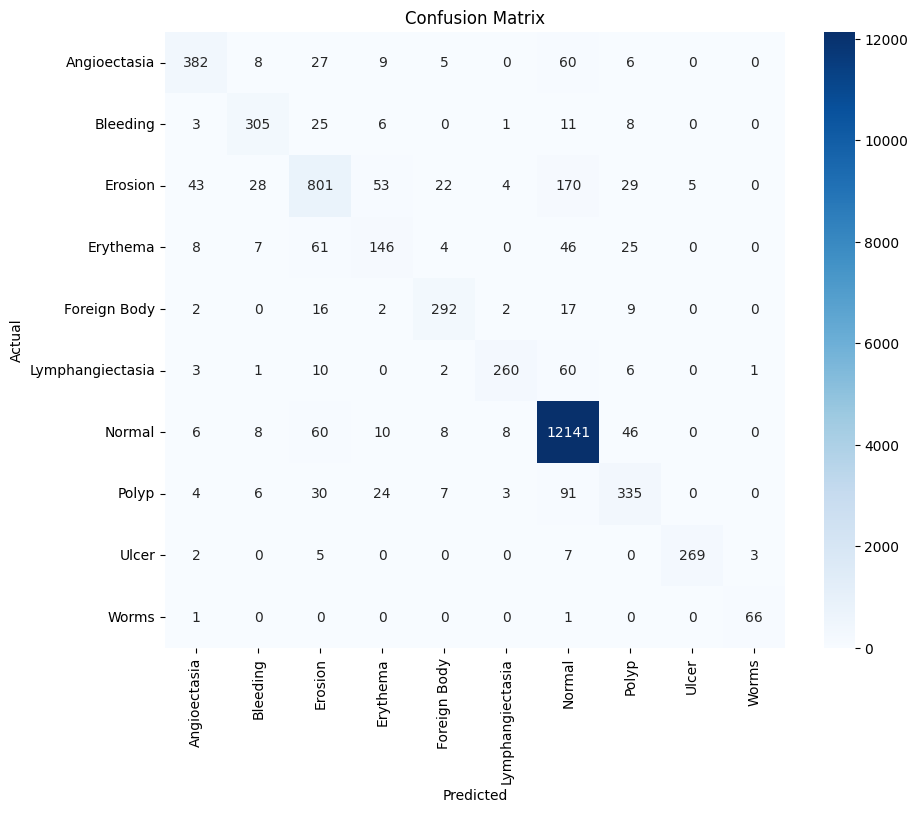

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
all_probs = []
all_true = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_true.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_true = np.hstack(all_true)
n_classes = 10
true_one_hot = np.zeros((len(all_true), n_classes))
true_one_hot[np.arange(len(all_true)), all_true] = 1

mean_auc = roc_auc_score(true_one_hot, all_probs, average="macro")
print(f"\n Mean AUC (Macro) on Validation Set: {mean_auc:.4f}")


 Mean AUC (Macro) on Validation Set: 0.9909
